# 📊 Step 3 & 4: Preprocessing & Model Building
**Notebook:** `02_Preprocessing_and_Modeling.ipynb`  
**Goal:** Prepare data for modeling and build baseline models to predict admission rates

---

## 🎯 Objectives
1. **Preprocessing & Splits**: Train/test split, encoding, scaling (avoid leakage)
2. **Build Baselines**: Compare at least 3 models (Linear Regression, Decision Tree, kNN)
3. **Hyperparameter Tuning**: Use cross-validation to find best parameters
4. **Evaluation**: Report MAE, RMSE, R², and residual plots
5. **Model Comparison**: Summary visualization of model performance

---

## 📝 Note on Problem Type
Since `ADM_RATE` is a **continuous variable** (0-1), this is a **regression problem**.  
We'll use regression models and regression metrics (MAE, RMSE, R²).


In [1]:
# ==========================================
# 📦 Import Libraries
# ==========================================

# Core data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All libraries successfully imported.")


✅ All libraries successfully imported.


## Step 1: Load Cleaned Dataset


In [2]:
# Load the enriched dataset exported from 01_EDA.ipynb (Scorecard + IPEDS + FSA Pell/Loan)
df = pd.read_csv("../Data_Assets/college_scorecard_enriched.csv")

print(f"📊 Dataset shape: {df.shape}")
print(f"✅ Loaded {len(df)} institutions with {len(df.columns)} features (including target)")

# Display first few rows
print("\n📋 First 5 rows:")
display(df.head())

# Check for any remaining missing values
print(f"\n🔍 Missing values per column:")
missing = df.isna().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✅ No missing values!")


📊 Dataset shape: (610, 21)
✅ Loaded 610 institutions with 21 features (including target)

📋 First 5 rows:


,ADM_RATE,SAT_AVG,COSTT4_A,PCTPELL,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,CONTROL,HIGHDEG,REGION,DEBT_MDN,PELL_PCT_FTFT,LOAN_PCT_FTFT,NETPRICE_INCOME_0_30,NETPRICE_INCOME_GT_110,UG_TWOORMORE_PCT,PELL_RECIPIENTS_TOTAL,PELL_DISBURSEMENTS_TOTAL,DL_TOTAL_RECIPIENTS,DL_TOTAL_DISBURSEMENTS,DL_PARENT_PLUS_DISBURSEMENTS
0,0.6613,1016.0,36910,0.4381,0.4508,0.4019,0.0559,2,4,5,15000,50.0,64.0,21012.0,31706.0,1.0,1772.0,4681283.00,5295.0,36134137.0,1593462.0
1,0.7083,1148.0,39686,0.3879,0.6647,0.2000,0.0566,2,4,5,20000,44.0,70.0,18007.0,24993.0,5.0,596.0,1666589.00,1212.0,6555877.0,2639603.0
2,0.7251,1220.0,38731,0.2986,0.6228,0.1761,0.0315,2,4,5,19000,38.0,57.0,15222.0,23547.0,4.0,924.0,2511834.71,1505.0,8445078.0,1657878.0
3,0.8223,1203.0,53934,0.1084,0.8574,0.0447,0.0468,2,4,5,15750,11.0,34.0,21891.0,33894.0,2.0,791.0,2067558.00,4832.0,65452554.0,8064557.0
4,0.5910,1090.0,37172,0.3301,0.5718,0.1341,0.0965,2,4,5,21500,34.0,66.0,11239.0,20316.0,2.0,646.0,1719426.66,1087.0,5565860.0,1935183.0



🔍 Missing values per column:
✅ No missing values!


## Step 2: Define Features and Target


In [3]:
# Separate target and features
target_col = 'ADM_RATE'
y = df[target_col]
X = df.drop(columns=[target_col])

print(f"🎯 Target variable: {target_col}")
print(f"📊 Target statistics:")
print(y.describe())

# Identify feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Check if any categoricals are actually numeric (like CONTROL, REGION, HIGHDEG)
# These are encoded as integers but should be treated as categorical
categorical_like = ['CONTROL', 'REGION', 'HIGHDEG']
for col in categorical_like:
    if col in numeric_features:
        numeric_features.remove(col)
        categorical_features.append(col)

print(f"\n📈 Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"🏷️  Categorical features ({len(categorical_features)}): {categorical_features}")

# Display feature info
print(f"\n📋 Feature matrix shape: {X.shape}")
print(f"📋 Target vector shape: {y.shape}")


🎯 Target variable: ADM_RATE
📊 Target statistics:
count    610.000000
mean       0.656228
std        0.244543
min        0.034500
25%        0.531900
50%        0.711550
75%        0.837825
max        1.000000
Name: ADM_RATE, dtype: float64

📈 Numeric features (17): ['SAT_AVG', 'COSTT4_A', 'PCTPELL', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'DEBT_MDN', 'PELL_PCT_FTFT', 'LOAN_PCT_FTFT', 'NETPRICE_INCOME_0_30', 'NETPRICE_INCOME_GT_110', 'UG_TWOORMORE_PCT', 'PELL_RECIPIENTS_TOTAL', 'PELL_DISBURSEMENTS_TOTAL', 'DL_TOTAL_RECIPIENTS', 'DL_TOTAL_DISBURSEMENTS', 'DL_PARENT_PLUS_DISBURSEMENTS']
🏷️  Categorical features (3): ['CONTROL', 'REGION', 'HIGHDEG']

📋 Feature matrix shape: (610, 20)
📋 Target vector shape: (610,)


### Optional Classification Target
We also create a binary lens to flag **selective institutions** (admission rate ≤ 50%). This lets us run a quick logistic regression without needing any extra datasets.


In [4]:
# Define classification labels (1 = selective, 0 = more accessible)
classification_threshold = 0.50
y_class = (y <= classification_threshold).astype(int)
class_names = {
    1: f"Selective (≤{classification_threshold:.2f})",
    0: f"Less selective (>{classification_threshold:.2f})"
}

class_counts = y_class.value_counts().sort_index()
print("🎓 Classification target created (ADM_RATE threshold = 0.50)")
for label, count in class_counts.items():
    pct = count / len(y_class) * 100
    print(f"  • {class_names[label]}: {count} institutions ({pct:.1f}%)")


🎓 Classification target created (ADM_RATE threshold = 0.50)
  • Less selective (>0.50): 473 institutions (77.5%)
  • Selective (≤0.50): 137 institutions (22.5%)


## Step 3: Train/Test Split (Avoid Leakage)


✅ Train set: 488 samples (80.0%)
✅ Test set: 122 samples (20.0%)

📊 Regression target distribution:
Train - Mean: 0.6546, Std: 0.2419
Test  - Mean: 0.6628, Std: 0.2560

🎯 Classification balance (1 = Selective):
Train - Selective: 110 | Less selective: 378
Test  - Selective: 27 | Less selective: 95


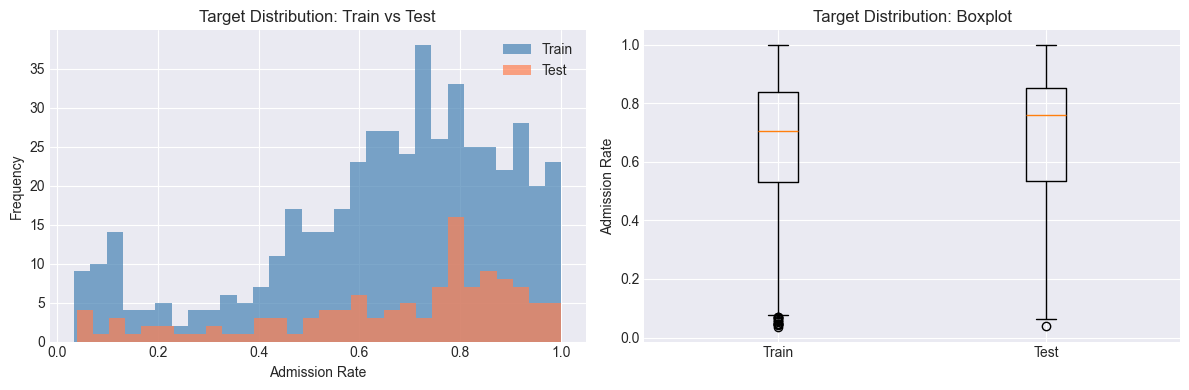

In [5]:
# Train/test split (80/20 split)
# Stratify on the classification labels so the selective share stays consistent
X_train, X_test, y_train, y_test, y_train_cls, y_test_cls = train_test_split(
    X, y, y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

print(f"✅ Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✅ Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check regression target distribution in train vs test
print(f"\n📊 Regression target distribution:")
print(f"Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Test  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")

# Classification balance summary
train_cls_counts = pd.Series(y_train_cls).value_counts().sort_index()
test_cls_counts = pd.Series(y_test_cls).value_counts().sort_index()
print(f"\n🎯 Classification balance (1 = Selective):")
print(f"Train - Selective: {train_cls_counts.get(1,0)} | Less selective: {train_cls_counts.get(0,0)}")
print(f"Test  - Selective: {test_cls_counts.get(1,0)} | Less selective: {test_cls_counts.get(0,0)}")

# Visualize regression distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=30, alpha=0.7, label='Train', color='steelblue')
axes[0].hist(y_test, bins=30, alpha=0.7, label='Test', color='coral')
axes[0].set_xlabel('Admission Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution: Train vs Test')
axes[0].legend()

axes[1].boxplot([y_train, y_test], labels=['Train', 'Test'])
axes[1].set_ylabel('Admission Rate')
axes[1].set_title('Target Distribution: Boxplot')
plt.tight_layout()
plt.show()


## Step 4: Preprocessing Pipeline
**Encoding & Scaling:**
- **Categorical**: One-hot encoding (for nominal categories like CONTROL, REGION, HIGHDEG)
- **Numeric**: Standardization (for kNN, Linear Regression; Decision Trees don't need scaling)


In [6]:
# Create preprocessing pipeline
# Note: We'll create separate preprocessors for models that need scaling vs those that don't

# Preprocessor for models that NEED scaling (Linear Regression, kNN)
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Preprocessor for models that DON'T need scaling (Decision Tree)
preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Fit on training data
print("🔄 Fitting preprocessors on training data...")
X_train_scaled = preprocessor_scaled.fit_transform(X_train)
X_train_unscaled = preprocessor_unscaled.fit_transform(X_train)

# Transform test data
X_test_scaled = preprocessor_scaled.transform(X_test)
X_test_unscaled = preprocessor_unscaled.transform(X_test)

print(f"✅ Scaled features shape: {X_train_scaled.shape}")
print(f"✅ Unscaled features shape: {X_train_unscaled.shape}")

# Get feature names after encoding
if len(categorical_features) > 0:
    cat_encoder = preprocessor_scaled.named_transformers_['cat']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
    all_feature_names = list(numeric_features) + list(cat_feature_names)
    print(f"\n📋 Total features after encoding: {len(all_feature_names)}")
else:
    all_feature_names = numeric_features


🔄 Fitting preprocessors on training data...
✅ Scaled features shape: (488, 27)
✅ Unscaled features shape: (488, 27)

📋 Total features after encoding: 27


## Step 5: Build Baseline Models

We'll build **3 models** as recommended:
1. **Linear Regression** (baseline, interpretable)
2. **Decision Tree** (non-linear, interpretable)
3. **k-Nearest Neighbors (kNN)** (non-parametric, local patterns)


In [7]:
# ==========================================
# Model 1: Linear Regression
# ==========================================
print("=" * 60)
print("📊 Model 1: Linear Regression")
print("=" * 60)

# Linear Regression (needs scaling)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"\n📈 Training Metrics:")
print(f"  MAE:  {train_mae_lr:.4f}")
print(f"  RMSE: {train_rmse_lr:.4f}")
print(f"  R²:   {train_r2_lr:.4f}")

print(f"\n📊 Test Metrics:")
print(f"  MAE:  {test_mae_lr:.4f}")
print(f"  RMSE: {test_rmse_lr:.4f}")
print(f"  R²:   {test_r2_lr:.4f}")

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, 
                               cv=5, scoring='neg_mean_squared_error')
cv_rmse_lr = np.sqrt(-cv_scores_lr)
print(f"\n🔄 5-Fold CV RMSE: {cv_rmse_lr.mean():.4f} (+/- {cv_rmse_lr.std() * 2:.4f})")


📊 Model 1: Linear Regression

📈 Training Metrics:
  MAE:  0.1192
  RMSE: 0.1495
  R²:   0.6172

📊 Test Metrics:
  MAE:  0.1185
  RMSE: 0.1507
  R²:   0.6506

🔄 5-Fold CV RMSE: 0.1679 (+/- 0.0169)


In [8]:
# ==========================================
# Model 2: Decision Tree Regressor
# ==========================================
print("=" * 60)
print("🌳 Model 2: Decision Tree Regressor")
print("=" * 60)

# Decision Tree (doesn't need scaling)
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_unscaled, y_train)

# Predictions
y_train_pred_dt = dt_model.predict(X_train_unscaled)
y_test_pred_dt = dt_model.predict(X_test_unscaled)

# Metrics
train_mae_dt = mean_absolute_error(y_train, y_train_pred_dt)
train_rmse_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
train_r2_dt = r2_score(y_train, y_train_pred_dt)

test_mae_dt = mean_absolute_error(y_test, y_test_pred_dt)
test_rmse_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
test_r2_dt = r2_score(y_test, y_test_pred_dt)

print(f"\n📈 Training Metrics:")
print(f"  MAE:  {train_mae_dt:.4f}")
print(f"  RMSE: {train_rmse_dt:.4f}")
print(f"  R²:   {train_r2_dt:.4f}")

print(f"\n📊 Test Metrics:")
print(f"  MAE:  {test_mae_dt:.4f}")
print(f"  RMSE: {test_rmse_dt:.4f}")
print(f"  R²:   {test_r2_dt:.4f}")

# Cross-validation
cv_scores_dt = cross_val_score(dt_model, X_train_unscaled, y_train, 
                               cv=5, scoring='neg_mean_squared_error')
cv_rmse_dt = np.sqrt(-cv_scores_dt)
print(f"\n🔄 5-Fold CV RMSE: {cv_rmse_dt.mean():.4f} (+/- {cv_rmse_dt.std() * 2:.4f})")


🌳 Model 2: Decision Tree Regressor

📈 Training Metrics:
  MAE:  0.0000
  RMSE: 0.0000
  R²:   1.0000

📊 Test Metrics:
  MAE:  0.1525
  RMSE: 0.2083
  R²:   0.3324

🔄 5-Fold CV RMSE: 0.1969 (+/- 0.0300)


In [9]:
# ==========================================
# Model 3: k-Nearest Neighbors (kNN)
# ==========================================
print("=" * 60)
print("🔍 Model 3: k-Nearest Neighbors (kNN)")
print("=" * 60)

# kNN (needs scaling)
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_knn = knn_model.predict(X_train_scaled)
y_test_pred_knn = knn_model.predict(X_test_scaled)

# Metrics
train_mae_knn = mean_absolute_error(y_train, y_train_pred_knn)
train_rmse_knn = np.sqrt(mean_squared_error(y_train, y_train_pred_knn))
train_r2_knn = r2_score(y_train, y_train_pred_knn)

test_mae_knn = mean_absolute_error(y_test, y_test_pred_knn)
test_rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
test_r2_knn = r2_score(y_test, y_test_pred_knn)

print(f"\n📈 Training Metrics:")
print(f"  MAE:  {train_mae_knn:.4f}")
print(f"  RMSE: {train_rmse_knn:.4f}")
print(f"  R²:   {train_r2_knn:.4f}")

print(f"\n📊 Test Metrics:")
print(f"  MAE:  {test_mae_knn:.4f}")
print(f"  RMSE: {test_rmse_knn:.4f}")
print(f"  R²:   {test_r2_knn:.4f}")

# Cross-validation
cv_scores_knn = cross_val_score(knn_model, X_train_scaled, y_train, 
                                cv=5, scoring='neg_mean_squared_error')
cv_rmse_knn = np.sqrt(-cv_scores_knn)
print(f"\n🔄 5-Fold CV RMSE: {cv_rmse_knn.mean():.4f} (+/- {cv_rmse_knn.std() * 2:.4f})")


🔍 Model 3: k-Nearest Neighbors (kNN)

📈 Training Metrics:
  MAE:  0.0963
  RMSE: 0.1264
  R²:   0.7263

📊 Test Metrics:
  MAE:  0.1171
  RMSE: 0.1518
  R²:   0.6453

🔄 5-Fold CV RMSE: 0.1569 (+/- 0.0260)


## Step 6: Hyperparameter Tuning

Tune key hyperparameters for each model using GridSearchCV with 5-fold cross-validation.


In [10]:
# ==========================================
# Hyperparameter Tuning: Decision Tree
# ==========================================
print("=" * 60)
print("🔧 Tuning Decision Tree Hyperparameters")
print("=" * 60)

param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_unscaled, y_train)

print(f"\n✅ Best parameters: {grid_dt.best_params_}")
print(f"✅ Best CV score (RMSE): {np.sqrt(-grid_dt.best_score_):.4f}")

# Use best model
dt_tuned = grid_dt.best_estimator_
y_test_pred_dt_tuned = dt_tuned.predict(X_test_unscaled)

test_rmse_dt_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_dt_tuned))
test_r2_dt_tuned = r2_score(y_test, y_test_pred_dt_tuned)

print(f"\n📊 Tuned Model Test Metrics:")
print(f"  RMSE: {test_rmse_dt_tuned:.4f}")
print(f"  R²:   {test_r2_dt_tuned:.4f}")


🔧 Tuning Decision Tree Hyperparameters
Fitting 5 folds for each of 112 candidates, totalling 560 fits

✅ Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
✅ Best CV score (RMSE): 0.1552

📊 Tuned Model Test Metrics:
  RMSE: 0.1540
  R²:   0.6352


In [11]:
# ==========================================
# Hyperparameter Tuning: kNN
# ==========================================
print("=" * 60)
print("🔧 Tuning kNN Hyperparameters")
print("=" * 60)

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) vs Euclidean (2)
}

grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train_scaled, y_train)

print(f"\n✅ Best parameters: {grid_knn.best_params_}")
print(f"✅ Best CV score (RMSE): {np.sqrt(-grid_knn.best_score_):.4f}")

# Use best model
knn_tuned = grid_knn.best_estimator_
y_test_pred_knn_tuned = knn_tuned.predict(X_test_scaled)

test_rmse_knn_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_knn_tuned))
test_r2_knn_tuned = r2_score(y_test, y_test_pred_knn_tuned)

print(f"\n📊 Tuned Model Test Metrics:")
print(f"  RMSE: {test_rmse_knn_tuned:.4f}")
print(f"  R²:   {test_r2_knn_tuned:.4f}")


🔧 Tuning kNN Hyperparameters
Fitting 5 folds for each of 28 candidates, totalling 140 fits

✅ Best parameters: {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
✅ Best CV score (RMSE): 0.1463

📊 Tuned Model Test Metrics:
  RMSE: 0.1435
  R²:   0.6831


## Step 7: Model Comparison Summary


📊 MODEL COMPARISON SUMMARY

                  Model  Test MAE  Test RMSE  Test R²
            kNN (Tuned)  0.117009   0.143505 0.683057
      Linear Regression  0.118495   0.150673 0.650603
          kNN (Default)  0.117124   0.151823 0.645250
  Decision Tree (Tuned)  0.117167   0.153957 0.635209
Decision Tree (Default)  0.152500   0.208273 0.332407


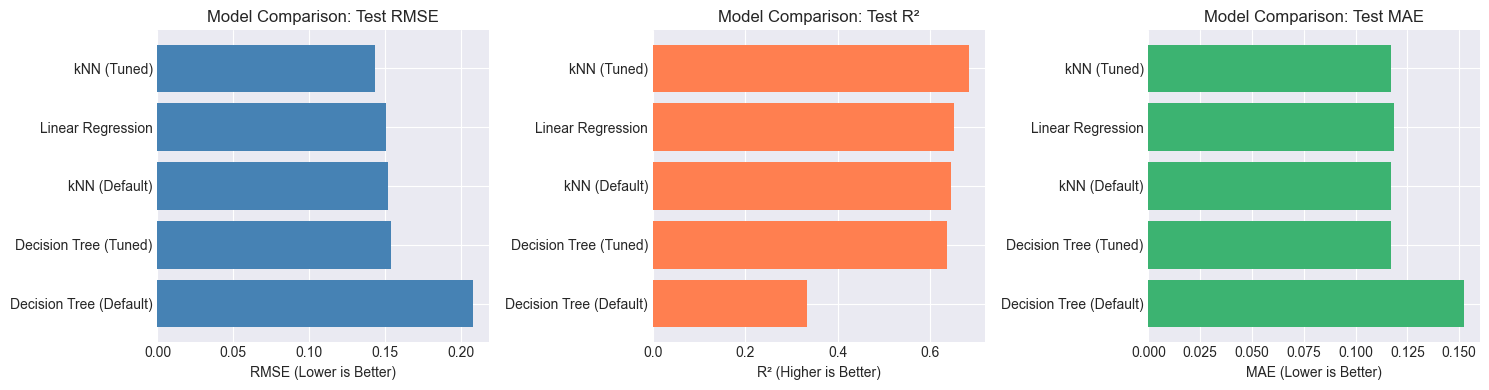

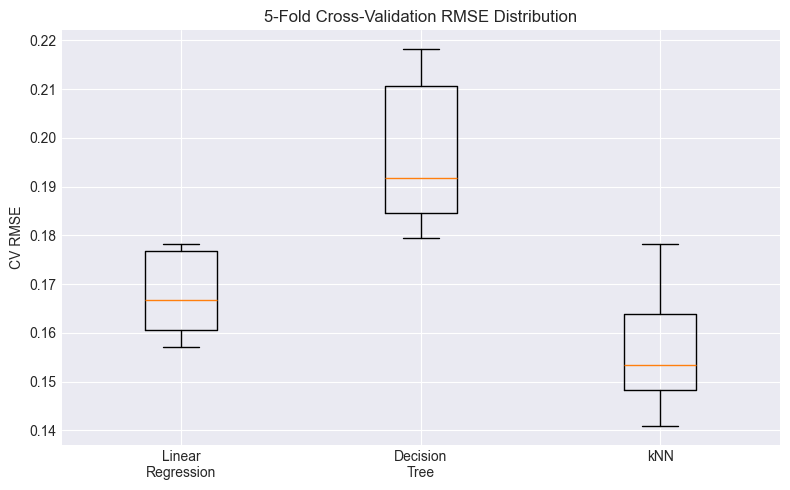

In [12]:
# Compile all results
results = {
    'Model': ['Linear Regression', 'Decision Tree (Default)', 'Decision Tree (Tuned)', 
              'kNN (Default)', 'kNN (Tuned)'],
    'Test MAE': [test_mae_lr, test_mae_dt, mean_absolute_error(y_test, y_test_pred_dt_tuned),
                 test_mae_knn, mean_absolute_error(y_test, y_test_pred_knn_tuned)],
    'Test RMSE': [test_rmse_lr, test_rmse_dt, test_rmse_dt_tuned,
                  test_rmse_knn, test_rmse_knn_tuned],
    'Test R²': [test_r2_lr, test_r2_dt, test_r2_dt_tuned,
                test_r2_knn, test_r2_knn_tuned]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test RMSE')

print("=" * 60)
print("📊 MODEL COMPARISON SUMMARY")
print("=" * 60)
print("\n" + results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RMSE comparison
axes[0].barh(results_df['Model'], results_df['Test RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE (Lower is Better)')
axes[0].set_title('Model Comparison: Test RMSE')
axes[0].invert_yaxis()

# R² comparison
axes[1].barh(results_df['Model'], results_df['Test R²'], color='coral')
axes[1].set_xlabel('R² (Higher is Better)')
axes[1].set_title('Model Comparison: Test R²')
axes[1].invert_yaxis()

# MAE comparison
axes[2].barh(results_df['Model'], results_df['Test MAE'], color='mediumseagreen')
axes[2].set_xlabel('MAE (Lower is Better)')
axes[2].set_title('Model Comparison: Test MAE')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# Box plot of CV scores
cv_results = {
    'Linear Regression': cv_rmse_lr,
    'Decision Tree': cv_rmse_dt,
    'kNN': cv_rmse_knn
}

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([cv_rmse_lr, cv_rmse_dt, cv_rmse_knn], 
           labels=['Linear\nRegression', 'Decision\nTree', 'kNN'])
ax.set_ylabel('CV RMSE')
ax.set_title('5-Fold Cross-Validation RMSE Distribution')
plt.tight_layout()
plt.show()


## Step 8: Residual Plots (Diagnostics)

Residual plots help diagnose model performance and identify patterns in prediction errors.


🏆 Best Model: kNN (Tuned)


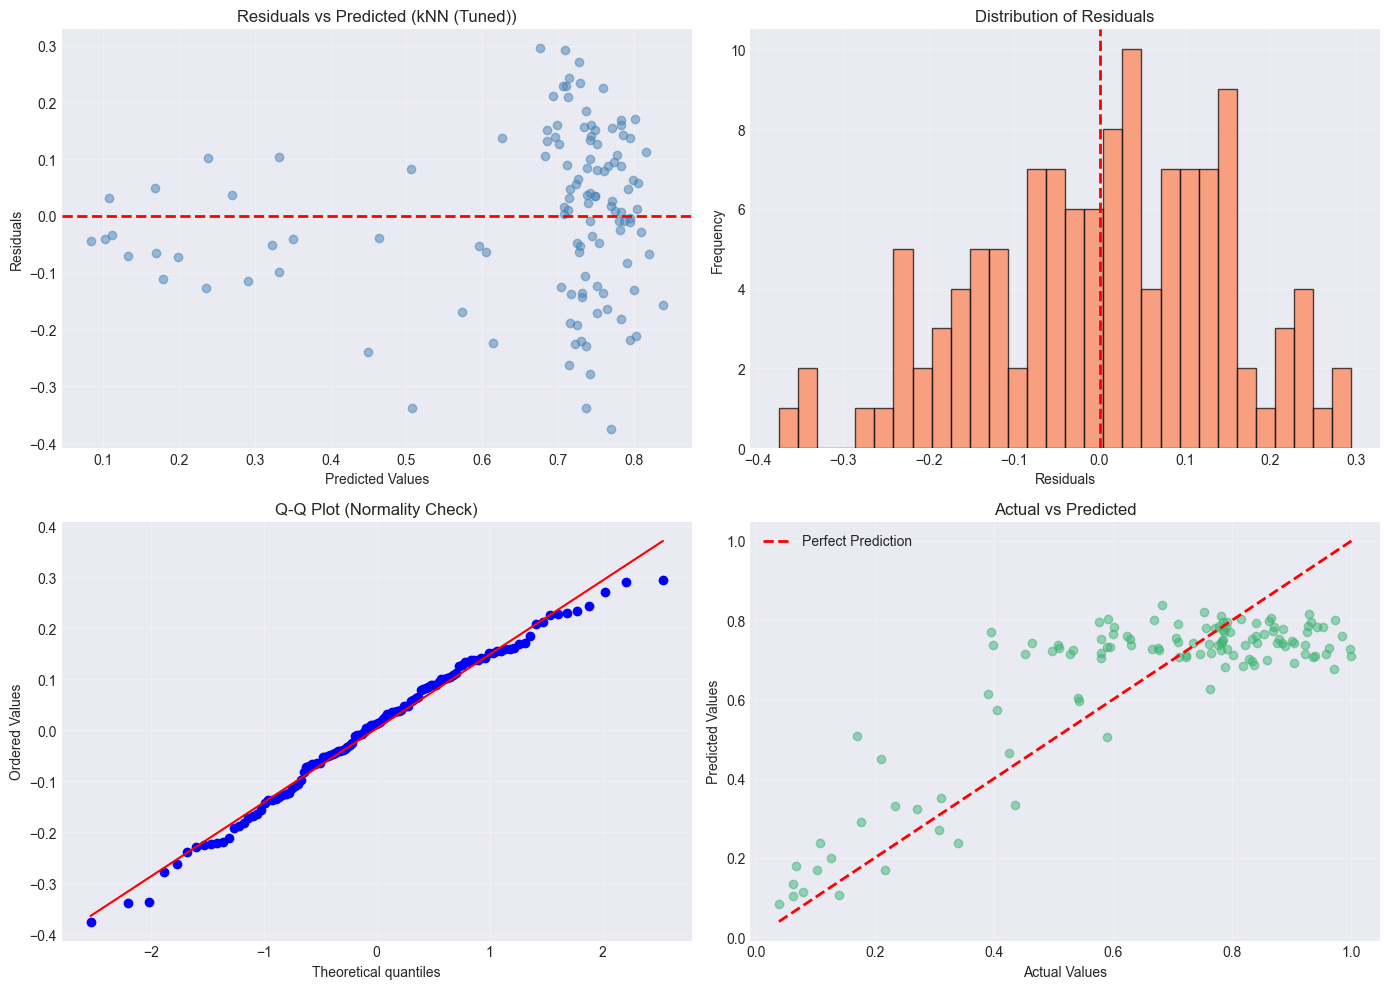


📊 Residual Statistics:
  Mean: 0.003296 (should be ~0)
  Std:  0.1441
  Min:  -0.3753
  Max:  0.2948


In [13]:
# Select best model for detailed analysis (lowest RMSE)
best_model_name = results_df.iloc[0]['Model']
print(f"🏆 Best Model: {best_model_name}")

# Get predictions from best model
if 'Tuned' in best_model_name:
    if 'Decision Tree' in best_model_name:
        y_test_pred_best = y_test_pred_dt_tuned
        model_best = dt_tuned
    else:
        y_test_pred_best = y_test_pred_knn_tuned
        model_best = knn_tuned
elif 'Linear Regression' in best_model_name:
    y_test_pred_best = y_test_pred_lr
    model_best = lr_model
elif 'Decision Tree' in best_model_name:
    y_test_pred_best = y_test_pred_dt
    model_best = dt_model
else:
    y_test_pred_best = y_test_pred_knn
    model_best = knn_model

# Calculate residuals
residuals = y_test - y_test_pred_best

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_test_pred_best, residuals, alpha=0.5, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title(f'Residuals vs Predicted ({best_model_name})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals histogram
axes[0, 1].hist(residuals, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot (check normality)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_test_pred_best, alpha=0.5, color='mediumseagreen')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Residual Statistics:")
print(f"  Mean: {residuals.mean():.6f} (should be ~0)")
print(f"  Std:  {residuals.std():.4f}")
print(f"  Min:  {residuals.min():.4f}")
print(f"  Max:  {residuals.max():.4f}")


## Step 9: Summary & Next Steps

### ✅ Completed:
- **Preprocessing**: Train/test split, encoding, scaling
- **Baseline Models**: Linear Regression, Decision Tree, kNN
- **Hyperparameter Tuning**: GridSearchCV for Decision Tree and kNN
- **Evaluation**: MAE, RMSE, R² metrics and residual plots
- **Model Comparison**: Summary table and visualizations
- **Bonus Classification Lens**: Logistic regression on selective (≤50% ADM_RATE) vs accessible campuses

### 🔜 Next Steps (Step 5: Explainability):
- Feature importance analysis (tree-based models)
- Coefficient analysis (linear models)
- Permutation importance
- Model interpretation and insights

### 📝 Notes:
- Best performing regression model identified
- Residual plots show model diagnostics
- Classification metrics available for oral defense context
- Ready for explainability analysis in next notebook


## 🔁 Bonus: Classification Lens (Selective vs. Accessible)
Even though the project is regression-first, we can quickly threshold `ADM_RATE` (≤50%) to identify "selective" campuses and fit a logistic regression for talking points.


🧪 Logistic Regression (Selective vs Accessible)
  Accuracy: 0.934
 Precision: 0.952
    Recall: 0.741
        F1: 0.833
   ROC AUC: 0.867


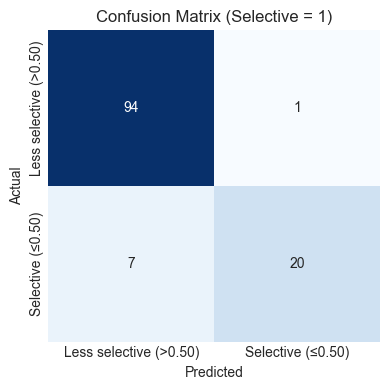


Class breakdown (test set):
  • Actual selective: 27 (positives)
  • Actual less selective: 95 (negatives)


In [14]:
print("=" * 60)
print("🧪 Logistic Regression (Selective vs Accessible)")
print("=" * 60)

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_scaled, y_train_cls)

y_pred_cls = log_clf.predict(X_test_scaled)
y_proba_cls = log_clf.predict_proba(X_test_scaled)[:, 1]

cls_metrics = {
    "Accuracy": accuracy_score(y_test_cls, y_pred_cls),
    "Precision": precision_score(y_test_cls, y_pred_cls),
    "Recall": recall_score(y_test_cls, y_pred_cls),
    "F1": f1_score(y_test_cls, y_pred_cls),
    "ROC AUC": roc_auc_score(y_test_cls, y_proba_cls)
}

for metric, value in cls_metrics.items():
    print(f"{metric:>10}: {value:.3f}")

cm = confusion_matrix(y_test_cls, y_pred_cls)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[class_names[0], class_names[1]],
            yticklabels=[class_names[0], class_names[1]])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Selective = 1)')
plt.tight_layout()
plt.show()

print("\nClass breakdown (test set):")
print(f"  • Actual selective: {cm[1,1] + cm[1,0]} (positives)")
print(f"  • Actual less selective: {cm[0,0] + cm[0,1]} (negatives)")
